# Modelling

### Libraries

In [13]:
# import libraries

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Data

In [2]:
# load review sentiment data

review_df = pd.read_csv('data/review_sentiment.csv')

review_df

,review_id,text,sentiment
0,NvusujU9_5pIUbn9SZ6hMA,Stopped by to munch a burger during today's Se...,1
1,vHOeBa7aMA_na4rfS2Db5A,"Yelp doesn't allow to leave 0 star review, so ...",-1
2,hG9RTxxivb0ZXzEk4JXTXA,I find it hard to believe there are so many pe...,-1
3,zIVkwgahZjOneChZFUYY4g,Love this place! Almost all of their menu item...,1
4,DLczAuvMAlAnY5EeDGhTVg,Excellent customer service. I wish I could ren...,1
...,...,...,...
63446,OgoBp7fbXnLSKvsQb4O_tw,"I really loved the food and service. I mean, t...",1
63447,Q7e8EtZMmdknDrQE7huMoQ,Their Grove location was the bomb. Delicious f...,1
63448,zzMW6zbsFaQMjoGu2bGVdA,A nice ean BBQ joint right across from some ne...,1
63449,scgoa60EvhW2Mz7JMqLYGw,The perfect Hookah bar. I'm not sure what they...,1


### Train/test sets

In [3]:
# select and load feature data

feature_set = {
    0: 'bag_of_words',
    1: 'one_hot',
    2: 'n_grams',
    3: 'tf_idf',
    4: 'word2vec'
}
selected = 4

X = None
if selected == 4:
    X = np.load('features/' + feature_set[selected] + '.npy')
else:
    X = sparse.load_npz('features/' + feature_set[selected] + '.npz')
    
X.shape

(63451, 7500)

In [4]:
# target labels

y = review_df['sentiment']

y.shape

(63451,)

In [5]:
# split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(50760, 7500) (50760,)
(12691, 7500) (12691,)

Label distribution in the training set:
sentiment
 1    34075
-1    11791
 0     4894
Name: count, dtype: int64

Label distribution in the test set:
sentiment
 1    8605
-1    2868
 0    1218
Name: count, dtype: int64


In [6]:
# oversampling to balance the classes

oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train.to_numpy())

print(X_train_resampled.shape, y_train_resampled.shape)

print("\nLabel distribution after oversampling:")
print(pd.DataFrame(y_train_resampled).value_counts())

(102225, 7500) (102225,)

Label distribution after oversampling:
0 
-1    34075
 0    34075
 1    34075
Name: count, dtype: int64


### Classifier training

In [7]:
# classifiers

classifiers = {
    'gaussian_nb': GaussianNB(),
    'logistic_regression': LogisticRegression(random_state=0),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'svm': SVC(),
    'perceptron': Perceptron(tol=1e-3, random_state=0),
    'xgb': XGBClassifier()
}

In [8]:
# train a classifier

selected = 'gaussian_nb'
clf = classifiers[selected]
clf.fit(X_train_resampled, y_train_resampled)

GaussianNB()

In [36]:
# save classifier model

joblib.dump(clf, 'models/' + selected + '.plk')

['models/gaussian_nb.plk']

In [10]:
# load a classifier model

model = 'gaussian_nb'
clf = joblib.load('models/' + model + '.plk')

In [11]:
# get predictions

y_pred_clf = clf.predict(X_test)
print(y_pred_clf)

[-1  0  1 ...  1  0  1]


In [34]:
# cross-validation

folds = 5
cv_scores = cross_validate(clf, X, y, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], cv=folds)

In [16]:
# VADER sentiment analysis

vader = SentimentIntensityAnalyzer()
res = []
y_pred_vader = []
for review in review_df['text']:
    sentiment = vader.polarity_scores(review)
    res.append(sentiment)
    pred = round(sentiment['compound'])
    y_pred_vader.append(pred)

res

[{'neg': 0.031, 'neu': 0.914, 'pos': 0.055, 'compound': 0.594},
 {'neg': 0.104, 'neu': 0.86, 'pos': 0.035, 'compound': -0.906},
 {'neg': 0.056, 'neu': 0.846, 'pos': 0.097, 'compound': 0.9416},
 {'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'compound': 0.9647},
 {'neg': 0.0, 'neu': 0.675, 'pos': 0.325, 'compound': 0.9018},
 {'neg': 0.072, 'neu': 0.694, 'pos': 0.233, 'compound': 0.9161},
 {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.8908},
 {'neg': 0.031, 'neu': 0.883, 'pos': 0.085, 'compound': 0.7678},
 {'neg': 0.1, 'neu': 0.834, 'pos': 0.066, 'compound': -0.9218},
 {'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.8481},
 {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.7387},
 {'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'compound': -0.5994},
 {'neg': 0.006, 'neu': 0.855, 'pos': 0.138, 'compound': 0.9834},
 {'neg': 0.066, 'neu': 0.85, 'pos': 0.084, 'compound': -0.2001},
 {'neg': 0.08, 'neu': 0.783, 'pos': 0.137, 'compound': 0.8155},
 {'neg': 0.0, 'neu': 0.67, 'pos': 0.33

### Model performance

In [22]:
def evaluate_model(y_test, y_pred):
    '''
    Evaluate the performance of a multi-label classifier
    '''
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Confusion Matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

In [23]:
# performance metrics - classifier

evaluate_model(y_test, y_pred_clf)

Confusion Matrix:
[[1647  656  565]
 [ 260  693  265]
 [1462 4003 3140]]
Accuracy: 0.4318020644551257
Precision: 0.6591882623351613
Recall: 0.4318020644551257
F1-score: 0.47821424924334843


In [35]:
# cross-validation results

cv_scores

{'fit_time': array([74.54218864, 18.37000179, 13.16453099, 11.88200736,  7.35414076]),
 'score_time': array([3.89942718, 2.87473869, 2.63208103, 2.6397779 , 2.54929256]),
 'test_accuracy': array([0.43660862, 0.44452325, 0.41954295, 0.41938534, 0.4427108 ]),
 'test_precision_macro': array([0.47042863, 0.48291362, 0.4657665 , 0.45711385, 0.47392931]),
 'test_recall_macro': array([0.50282149, 0.51362154, 0.48546487, 0.48976482, 0.51014882]),
 'test_f1_macro': array([0.4163467 , 0.42635504, 0.40344883, 0.39979497, 0.4205195 ])}

In [25]:
# performance metrics - VADER

y_true = review_df['sentiment']
y_true = y_true.values

evaluate_model(y_true, y_pred_vader)

Confusion Matrix:
[[ 5712  4223  4724]
 [  401  1142  4569]
 [  236  1764 40680]]
Accuracy: 0.7491450095349167
Precision: 0.7708396510381877
Recall: 0.7491450095349167
F1-score: 0.7329072672012175


In [32]:
# dataframe with VADER sentiment scores

vader_df = pd.DataFrame(res)
vader_df = vader_df['compound']
vader_df = pd.concat([review_df, vader_df], axis=1)

vader_df

,review_id,text,sentiment,compound
0,NvusujU9_5pIUbn9SZ6hMA,Stopped by to munch a burger during today's Se...,1,0.5940
1,vHOeBa7aMA_na4rfS2Db5A,"Yelp doesn't allow to leave 0 star review, so ...",-1,-0.9060
2,hG9RTxxivb0ZXzEk4JXTXA,I find it hard to believe there are so many pe...,-1,0.9416
3,zIVkwgahZjOneChZFUYY4g,Love this place! Almost all of their menu item...,1,0.9647
4,DLczAuvMAlAnY5EeDGhTVg,Excellent customer service. I wish I could ren...,1,0.9018
...,...,...,...,...
63446,OgoBp7fbXnLSKvsQb4O_tw,"I really loved the food and service. I mean, t...",1,0.9729
63447,Q7e8EtZMmdknDrQE7huMoQ,Their Grove location was the bomb. Delicious f...,1,0.9955
63448,zzMW6zbsFaQMjoGu2bGVdA,A nice ean BBQ joint right across from some ne...,1,0.9890
63449,scgoa60EvhW2Mz7JMqLYGw,The perfect Hookah bar. I'm not sure what they...,1,0.9729


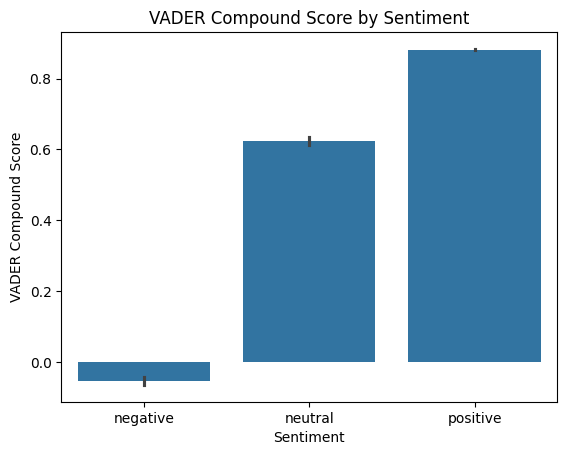

In [33]:
# visualize VADER compound scores by sentiment

negative_scores = vader_df[vader_df['sentiment'] == -1]['compound']
neutral_scores = vader_df[vader_df['sentiment'] == 0]['compound']
positive_scores = vader_df[vader_df['sentiment'] == 1]['compound']
all_scores = pd.concat([negative_scores, neutral_scores, positive_scores])

sentiments = ['negative'] * len(negative_scores) + ['neutral'] * len(neutral_scores) + ['positive'] * len(positive_scores)
sentiment_scores = pd.DataFrame({'sentiment': sentiments, 'compound': all_scores})

sns.barplot(data=sentiment_scores, x='sentiment', y='compound')
plt.xlabel('Sentiment')
plt.ylabel('VADER Compound Score')
plt.title('VADER Compound Score by Sentiment')
plt.show()